In [ ]:
# !git clone https://www.github.com/matterport/Mask_RCNN
# !pip install pycocotools
# !git clone https://github.com/atakanady/brain-tumor
# !pip install -r requirements.txt
# !python3 setup.py install

In [2]:
from IPython.display import clear_output
import os 
import sys
from tqdm import tqdm
import cv2
import numpy as np
import json
import skimage.draw
import matplotlib
import matplotlib.pyplot as plt
import random


ROOT_DIR = os.path.abspath('Mask_RCNN-_V1/')
sys.path.append(ROOT_DIR) 

from mrcnn.config import Config
from mrcnn import utils
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn import visualize
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))
import coco

plt.rcParams['figure.facecolor'] = 'white' 

clear_output()

In [3]:
MODEL_DIR = os.path.join(ROOT_DIR, 'logs') 
DATASET_DIR = 'brain-tumor/data_cleaned/'
DEFAULT_LOGS_DIR = 'logs' 


COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [4]:
class TumorConfig(Config):
    
    
    NAME = 'tumor_detector'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    
    NUM_CLASSES = 1 + 1 
      
    
    DETECTION_MIN_CONFIDENCE = 0.85    
    STEPS_PER_EPOCH = 100
    LEARNING_RATE = 0.001
    
config = TumorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [5]:
class BrainScanDataset(utils.Dataset):

    def load_brain_scan(self, dataset_dir, subset):
    
        self.add_class("tumor", 1, "tumor")
        
        assert subset in ["train", "val", 'test']
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(DATASET_DIR, subset, 'annotations_'+subset+'.json')))
        annotations = list(annotations.values()) 
        
        annotations = [a for a in annotations if a['regions']]

        
        for a in annotations:

            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]

    
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "tumor",
                image_id=a['filename'], 
                path=image_path,
                width=width, 
                height=height,
                polygons=polygons
            )

    def load_mask(self, image_id):

      
        image_info = self.image_info[image_id]
        if image_info["source"] != "tumor":
            return super(self.__class__, self).load_mask(image_id)
        
        
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
        
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
            
        
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        
        info = self.image_info[image_id]
        if info["source"] == "tumor":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [6]:
dataset_train = BrainScanDataset()
dataset_train.load_brain_scan(DATASET_DIR, 'train')
dataset_train.prepare()

dataset_val = BrainScanDataset()
dataset_val.load_brain_scan(DATASET_DIR, 'val')
dataset_val.prepare()

dataset_test = BrainScanDataset()
dataset_test.load_brain_scan(DATASET_DIR, 'test')
dataset_test.prepare()

brain-tumor/data_cleaned/train\12.jpg


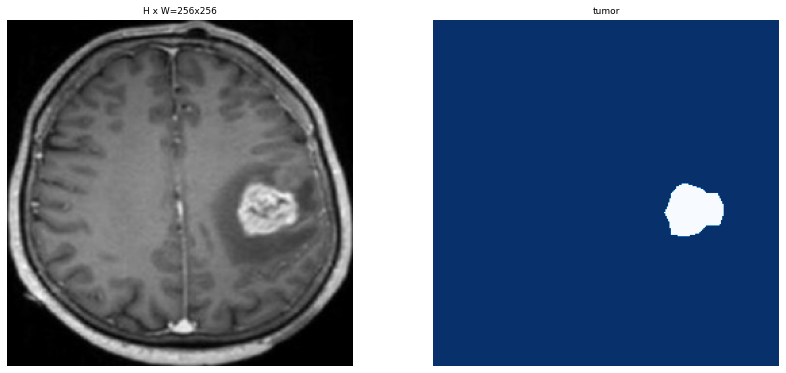

In [7]:
print(dataset_train.image_reference(6))
image = dataset_train.load_image(6)
mask, class_ids = dataset_train.load_mask(6)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

brain-tumor/data_cleaned/train\63.jpg


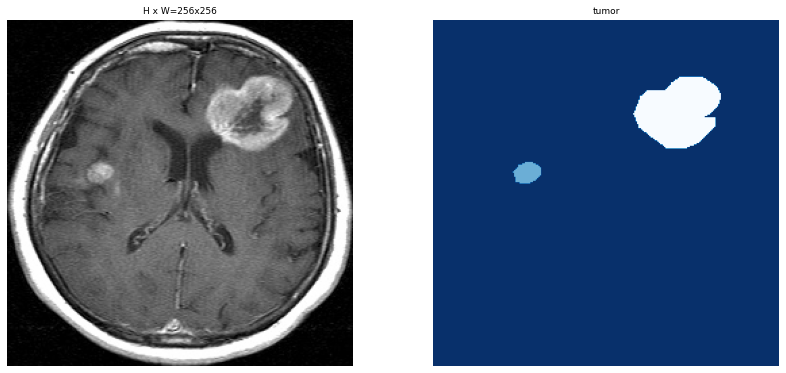

In [8]:
print(dataset_train.image_reference(30))
image = dataset_train.load_image(30)
mask, class_ids = dataset_train.load_mask(30)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

In [8]:
#-------------- Create model object in training mode------------------------
model = modellib.MaskRCNN(
    mode='training', 
    config=config, 
    model_dir=DEFAULT_LOGS_DIR
)
#-------------- Load weights trained on MS-COCO ---------------------------
model.load_weights(
    COCO_MODEL_PATH, 
    by_name=True, 
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
)
clear_output()

In [9]:
histroy = model.train(
    dataset_train, dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=7,
    layers='heads',
)


Starting at epoch 0. LR=0.001

Checkpoint Path: logs\tumor_detector20220110T2118\mask_rcnn_tumor_detector_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4  

C:\Users\jumpx\anaconda3\envs\rcnn\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/7
100/100 [==============================] - 3869s 39s/step - loss: 1.7859 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.6193 - mrcnn_class_loss: 0.1096 - mrcnn_bbox_loss: 0.5589 - mrcnn_mask_loss: 0.4677 - val_loss: 1.4521 - val_rpn_class_loss: 0.0397 - val_rpn_bbox_loss: 0.5819 - val_mrcnn_class_loss: 0.0495 - val_mrcnn_bbox_loss: 0.4199 - val_mrcnn_mask_loss: 0.3612
Epoch 2/7
100/100 [==============================] - 3868s 39s/step - loss: 0.7645 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1909 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.2677 - mrcnn_mask_loss: 0.2463 - val_loss: 1.4121 - val_rpn_class_loss: 0.0322 - val_rpn_bbox_loss: 0.5521 - val_mrcnn_class_loss: 0.0564 - val_mrcnn_bbox_loss: 0.4247 - val_mrcnn_mask_loss: 0.3466
Epoch 3/7
100/100 [==============================] - 3861s 39s/step - loss: 0.5416 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.1301 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.1674 - mrcnn_mask_loss: 0.1995 - val_loss: 1.4435 - val_rpn_clas

In [9]:
def display_image(dataset, ind):
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image')
    plt.show()
def get_ax(rows=1, cols=1, size=5):
    
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

def predict_and_plot_differences(dataset, img_id):
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
    modellib.load_image_gt(dataset, config, img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]

    visualize.display_differences(
        original_image,
        gt_box, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        class_names = ['tumor'], title="", ax=get_ax(),
        show_mask=True, show_box=True)

In [20]:
model = modellib.MaskRCNN(
    mode="inference", 
    config=config,
    model_dir=DEFAULT_LOGS_DIR
)


model_path = model.find_last()

print("Loading weights from ", model_path)
history = model.load_weights(model_path, by_name=True)
history

Loading weights from  logs\tumor_detector20220110T2118\mask_rcnn_tumor_detector_0007.h5
Re-starting from epoch 7


Sample 1


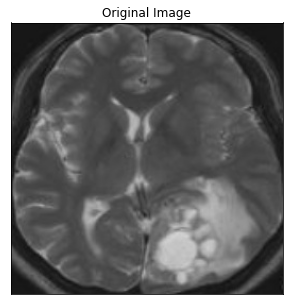

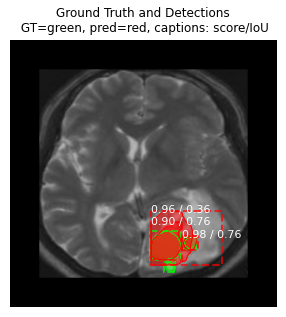

In [22]:
print("Sample 1")
ind = 5
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

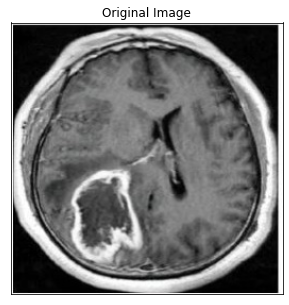

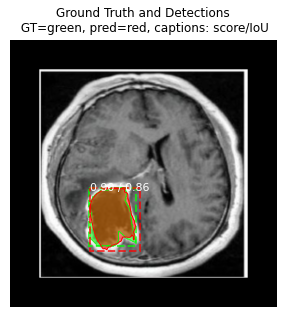

In [23]:
ind = 2
display_image(dataset_test, ind)
predict_and_plot_differences(dataset_test, ind)

In [21]:
loss: 1.7859 
rpn_class_loss: 0.0305
rpn_bbox_loss: 0.6193 
mrcnn_class_loss: 0.1096 
mrcnn_bbox_loss: 0.5589
mrcnn_mask_loss: 0.4677 
val_loss: 1.4521 
val_rpn_class_loss: 0.0397
val_rpn_bbox_loss: 0.5819 
val_mrcnn_class_loss: 0.0495 
val_mrcnn_bbox_loss: 0.4199 
val_mrcnn_mask_loss: 0.3612

TypeError: 'NoneType' object is not subscriptable

In [ ]:
loss: 0.7645
rpn_class_loss: 0.0158
rpn_bbox_loss: 0.1909
mrcnn_class_loss: 0.0437 
mrcnn_bbox_loss: 0.2677
mrcnn_mask_loss: 0.2463
val_loss: 1.4121
val_rpn_class_loss: 0.0322
val_rpn_bbox_loss: 0.5521
val_mrcnn_class_loss: 0.0564
val_mrcnn_bbox_loss: 0.4247 
val_mrcnn_mask_loss: 0.3466

In [ ]:
loss: 0.5416 
rpn_class_loss: 0.0124
rpn_bbox_loss: 0.1301
mrcnn_class_loss: 0.0323
mrcnn_bbox_loss: 0.1674
mrcnn_mask_loss: 0.1995
val_loss: 1.4435
val_rpn_class_loss: 0.0314
val_rpn_bbox_loss: 0.6304
val_mrcnn_class_loss: 0.0545
val_mrcnn_bbox_loss: 0.4007
val_mrcnn_mask_loss: 0.3265

In [ ]:
loss: 0.4575
rpn_class_loss: 0.0101
rpn_bbox_loss: 0.1023 
mrcnn_class_loss: 0.0294 
mrcnn_bbox_loss: 0.1342
mrcnn_mask_loss: 0.1815 
val_loss: 1.3931
val_rpn_class_loss: 0.0293 
val_rpn_bbox_loss: 0.5541
val_mrcnn_class_loss: 0.0543
val_mrcnn_bbox_loss: 0.3927
val_mrcnn_mask_loss: 0.3627

In [ ]:
loss: 0.3732
rpn_class_loss: 0.0085
rpn_bbox_loss: 0.0768 
mrcnn_class_loss: 0.0251
mrcnn_bbox_loss: 0.1074
mrcnn_mask_loss: 0.1554 
val_loss: 1.5677
val_rpn_class_loss: 0.0348 
val_rpn_bbox_loss: 0.7380
val_mrcnn_class_loss: 0.0439
val_mrcnn_bbox_loss: 0.3722
val_mrcnn_mask_loss: 0.3789

In [ ]:
loss: 0.3222
rpn_class_loss: 0.0072 
rpn_bbox_loss: 0.0620 
mrcnn_class_loss: 0.0221
mrcnn_bbox_loss: 0.0847 
mrcnn_mask_loss: 0.1463
val_loss: 1.4812 
val_rpn_class_loss: 0.0342
val_rpn_bbox_loss: 0.6233 
val_mrcnn_class_loss: 0.0563 
val_mrcnn_bbox_loss: 0.3861 
val_mrcnn_mask_loss: 0.3814

In [ ]:
loss: 0.2883 
rpn_class_loss: 0.0066 
rpn_bbox_loss: 0.0512 
mrcnn_class_loss: 0.0218 
mrcnn_bbox_loss: 0.0818 
mrcnn_mask_loss: 0.1270 
val_loss: 1.4715 
val_rpn_class_loss: 0.0312 
val_rpn_bbox_loss: 0.5986 
val_mrcnn_class_loss: 0.0649 
val_mrcnn_bbox_loss: 0.3779 
val_mrcnn_mask_loss: 0.3990